In [2]:
import torch 
import torch.nn as nn
from torch.utils import data
import matplotlib.pyplot as plt
import builtins
import glob
import os
import zipfile
import numpy as np
import torchvision
from torchvision.transforms import ToTensor
import torchvision.models as models
from PIL import Image


In [3]:
default_device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(default_device)

cpu


In [4]:
def load_cats_dogs_dataset():
    check_image_dir('PetImages/Cat/*.jpg')
    check_image_dir('PetImages/Dog/*.jpg')
    dataset = torchvision.datasets.ImageFolder('PetImages', transform=common_transform())
    trainset, testset = torch.utils.data.random_split(dataset, [20000, len(dataset) - 20000])
    trainloader = torch.utils.data.DataLoader(trainset,batch_size=256)
    testloader = torch.utils.data.DataLoader(testset,batch_size=256)
    return dataset, trainloader, testloader, trainset, testset

def check_image(fn):
    try:
        im= Image.open(fn)
        im.verify()
        return True
    except:
        return False

def check_image_dir(path):
    for fn in glob.glob(path):
        if not check_image(fn):
            print("Corrupt image: {}".format(fn))
            os.remove(fn)

def common_transform():
    std_normalize = torchvision.transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229, 0.224, 0.225])
    trans = torchvision.transforms.Compose([torchvision.transforms.Resize(256), torchvision.transforms.CenterCrop(224), torchvision.transforms.ToTensor(), std_normalize])
    return trans

def display_dataset(dataset, n=10, classes=None):
    fig,ax =plt.subplots(1,n,figsize=(15,3))
    mn = min([dataset[i][0].min() for i in range(n)])
    mx = max([dataset[i][0].max() for i in range(n)])
    for i in range(n):
        ax[i].imshow(np.transpose((dataset[i][0] - mn)/(mx - mn),(1,2,0)))
        ax[i].axis('off')
        if classes:
            ax[i].set_title(classes[dataset[i][1]])




In [5]:
def train_epoch(vgg16, dataloader, lr=0.01, optimizer=None, loss_fn= nn.NLLLoss()):
    optimizer = optimizer or torch.optim.Adam(net.parameters(), lr=lr)
    vgg16.train()
    total_loss,acc,count = 0,0,0
    for features,labels in dataloader:
        optimizer.zero_grad()
        lbls = labels.to(default_device)
        out = vgg16(features.to(default_device))
        loss = loss_fn(out,lbls)
        optimizer.step()
        total_loss += loss
        _,predicted = torch.max(out,1)
        acc+=(predicted == lbls).sum()
        count+=len(labels)
    return total_loss.item()/count, acc.item()/count

def validate(vgg16, dataloader, loss_fn = nn.NLLLoss()):
    vgg16.eval()
    count,acc,loss = 0,0,0
    with torch.no_grad():
        for features, labels in dataloader:
            lbls = labels.to(default_device)
            out =vgg16(features.to(default_device))
            loss += loss_fn(out,lbls)
            pred = torch.max(out,1)[1]
            acc += (pred == lbls).sum()
            count += len(labels)
    return loss.item()/count , acc.item()/count

def train(vgg16,train_loader,test_loader,optimizer=None,lr=0.01,epochs=2,loss_fn=nn.NLLLoss()):
    optimizer = optimizer or torch.optim.Adam(vgg16.parameters(),lr=lr)
    res = { 'train_loss' : [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    for ep in range(epochs):
        tl,ta = train_epoch(vgg16,train_loader,optimizer=optimizer,lr=lr,loss_fn=loss_fn)
        vl,va = validate(vgg16,test_loader,loss_fn=loss_fn)
        print(f"Epoch {ep:2}, Train acc={ta:.3f}, Val acc={va:.3f}, Train loss={tl:.3f}, Val loss={vl:.3f}")
        res['train_loss'].append(tl)
        res['train_acc'].append(ta)
        res['val_loss'].append(vl)
        res['val_acc'].append(va)
    return res

def train_long(vgg16, train_loader, test_loader, optimizer = None, lr=0.01, epochs =2, loss_fn = nn.NLLLoss(), print_freq=10):
    optimizer = optimizer or torch.optim.Adam(vgg16.parameters(), lr=lr)
    for epoch in range(epochs):
        vgg16.train()
        total_loss,acc,count = 0,0,0
        for i,(features,labels) in enumerate(train_loader):
            lbls = labels.to(default_device)
            optimizer.zero_grad()
            out = vgg16(features.to(default_device))
            loss = loss_fn(out, lbls)
            loss.backward()
            optimizer.step()
            total_loss += loss
            _,predicted = torch.max(out,1)
            acc+=(predicted==lbls).sum()
            count+=len(labels)
            if i%print_freq==0:
                print("Epoch {}, minibatch {}: train acc={}, train loss = {}".format(epoch,i,acc.item()/count,total_loss.item()/count))
        vl,va = validate(vgg16,test_loader,loss_fn)
        print("Epoch {} done, validation acc = {}, validation loss = {}".format(epoch,va,vl))


In [6]:
def plot_results(hist):
    plt.figure(figsize=(15,5))
    plt.subplot(121)
    plt.plot(hist['train_acc'], label='Training acc')
    plt.plot(hist['val_acc'], label='validation acc')
    plt.legend()
    plt.subplot(122)
    plt.plot(hist['train_loss'], label='Training loss')
    plt.plot(hist['val_loss'], label='Validation loss')
    plt.legend()

def plot_convolution(t,title=''):
    with torch.no_grad():
        c=nn.Conv2d(kernel_size=(3,3), out_channels=1, in_channels=1)
        c.weight.copy_(t)
        fig, ax=plt.subplots(2,6,figsize=(8,3))
        fig.suptitle(title,fontsize=16)
        for i in range(5):
            im=data_train[i][0]
            ax[0][i].imshow(im[0])
            ax[1][i].imshow(c(im.unsqueeze(0))[0][0])
            ax[0][i].axis('off')
            ax[1][i].axis('off')
        ax[0,5].imshow(t)
        ax[0,5].axis('off')
        ax[1,5].axis('off')
        plt.show()

In [7]:
dataset, train_loader, test_loader, train_data, test_data= load_cats_dogs_dataset()

C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\PIL\TiffImagePlugin.py:868: UserWarning: Truncated File Read
  warnings.warn(str(msg))


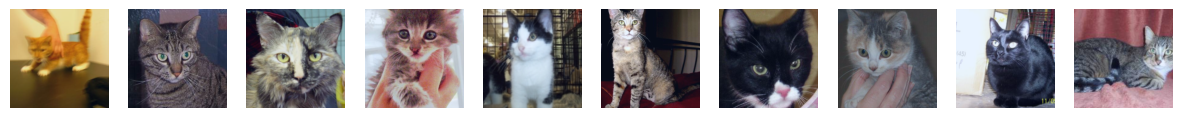

In [8]:
display_dataset(dataset, n=10, classes=None)

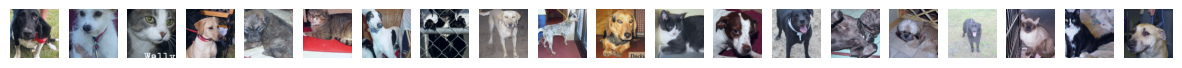

In [9]:
display_dataset(train_data, n=20, classes=None)

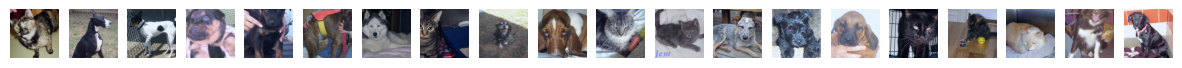

In [9]:
display_dataset(test_data, n=20, classes=None)

In [13]:
vgg16 = models.vgg16(pretrained=True)
for parma in vgg16.parameters():
    parma.requires_grad = False
vgg16.classifier = torch.nn.Sequential(
    torch.nn.Linear(in_features=25088, out_features=1000, bias=True),
    torch.nn.ReLU(inplace=True),
    torch.nn.Dropout(p=0.3),
    torch.nn.Linear(in_features=1000, out_features=512, bias=True),
    torch.nn.ReLU(inplace=True),
    torch.nn.Dropout(p=0.3),
    torch.nn.Linear(in_features=512, out_features=128, bias=True),
    torch.nn.ReLU(inplace=True),
    torch.nn.Dropout(p=0.3),
    torch.nn.Linear(in_features=128, out_features=2, bias=True)
)
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [22]:
model.to(default_device)

Sequential(
  (0): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16): M

In [ ]:
hist = train_long(vgg16, train_loader, test_loader)

Epoch 0, minibatch 0: train acc=0.4765625, train loss = 0.0003744467976503074
Epoch 0, minibatch 10: train acc=0.4989346590909091, train loss = -4677.183948863636


In [ ]:
plot_results(hist)